In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#from tqdm.notebook import tqdm
from tqdm import tqdm_notebook, tqdm
import os

### Preprocessing

In [3]:
stocks = pd.read_csv("nice_stocks_to_study.txt", index_col=0)

In [4]:
print(stocks.shape)
stocks.head()

(1716, 2)


,Stock_Exchange,Stock
0,Amsterdam,AALB
1,Amsterdam,AGN
2,Amsterdam,AKZA
3,Amsterdam,APAM
4,Amsterdam,ASML


In [5]:
common_stock_ex = [
    'CBOT-mini',
    'CME-eMini',
    'COMEX',
    'NYMEX',
    'ICE-Europe-Commodities',
    'CBOT',
    'Eurex',
    'Forex',
    'CME',
    'ICE-US'
]

In [6]:
asian_stock_ex = [
    'NIKKEI',
    'Shanghai',
    'Singapur',
    'Sydney',
    'Tokio',   
]

In [7]:
european_stock_ex = [
    'Amsterdam',
    'Athen',
    'Helsinki',
    'Johannesburg',  # South Africa but it has the same timezone as in NL
    'Kopenhagen',
    'Lissabon',
    'London',
    'Madrid',
    'Mailand', # Milan
    'Oslo',
    'Paris',
    'Stockholm',
    'Swiss-Exchange',
    'Xetra' # Deutsche Börse Xetra   
]

In [8]:
american_stock_ex = [
    'NASDAQ',
    'NYSE',
    'NYSE-American',
    'OTC-Markets',
    'Toronto'
]

In [9]:
stocks_eu = stocks[(stocks['Stock_Exchange'].isin(european_stock_ex)) & (stocks['Stock'] != 'FBRIC')]

In [10]:
stocks_eu.groupby("Stock_Exchange")['Stock'].nunique().sort_values()

Stock_Exchange
Johannesburg        1
Helsinki            9
Lissabon           12
Kopenhagen         17
Athen              18
Oslo               20
Amsterdam          25
Mailand            31
Madrid             33
Swiss-Exchange     36
Stockholm          39
Paris              72
Xetra              79
London            148
Name: Stock, dtype: int64

## PREPROCESSING

In [31]:
PATH2018year = "../../2018year"   # all yearly data for each stock

OUT_FOLDER_SE = "../../2018_SE_AGG"   # output folder for aggregated data by STOCK_EXCHANGE
OUT_FOLDER_CLUSTERS = "../../2018_CLUSTER_AGG"   # output folder for aggregated data by CLUSTER

colnames = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']

1) aggregate data of one stock

In [32]:
def aggregate_one_stock_data(stock_name, value_columns, agg_interval, 
                             interpolate=None, vertical=True, stock_folder=PATH2018year):

    filename = "2018_" + stock_name + ".txt"
    stock_path = os.path.join(stock_folder, filename)

    s = pd.read_csv(stock_path, names=colnames)
    s['Timestamp'] = pd.to_datetime(s.apply(lambda row: str(row['Date']) + ' ' + str(row['Time']), axis=1))
    s.set_index("Timestamp", inplace=True)
    s = s[value_columns]
    s = s.resample(agg_interval, label='right', closed='right').mean()

    if interpolate:
        s = s.interpolate(method='linear',  limit=interpolate)

    s.dropna(inplace=True)
    s.rename(columns={col:stock_name+"_"+col+"_agg_"+agg_interval for col in s.columns}, inplace=True)
    
    if vertical:
        return s
    
    else:
        return s.T # not relevant but let's keep it

In [33]:
## Example

#s = aggregate_one_stock_data("Amsterdam_AALB", ["Open", "Close", "Volume"], "15min")
##s = aggregate_one_stock_data("Amsterdam_AALB", ["Open", "Close", "Volume"], "15min", interpolate=2)

#print(s.shape)
#s.head(3)

2) merge data of all stocks for a particular stock exchange

In [34]:
def aggregate_stocks_for_one_stock_exchange(stock_exchange_name, value_columns, agg_interval, 
                                            interpolate=None, vertical=True, stock_folder=PATH2018year, 
                                            output_folder=OUT_FOLDER_SE, dropna=True, write=True,
                                            name_appendix_value_columns=False):

    files = sorted(os.listdir(stock_folder))
    se_data = []

    for file in files:
        if (file.split("_")[1] == stock_exchange_name):
            print(file)
            stock = file.split("_")[2][:-4]  # cut .txt
            
            df = aggregate_one_stock_data(stock_name=stock_exchange_name + "_" + stock, 
                                          value_columns=value_columns,
                                          agg_interval=agg_interval,
                                          interpolate=interpolate,
                                          vertical=vertical,
                                          stock_folder=stock_folder)
            se_data.append(df)

    print(stock_exchange_name, ": Started writing...")
    if name_appendix_value_columns:
        appdx = "_cols_" + "_".join(value_columns)
    else:
        appdx=""
    output_filename = "2018_" + stock_exchange_name + appdx + "_agg_" + agg_interval + ".txt"
    
    if vertical:
        se_data = pd.concat(se_data, axis=1)
        print(f"Stock Exchange: {stock_exchange_name}, data.shape: {se_data.shape}, " + \
               f"data.dropna().shape: {se_data.dropna().shape}")
                # index=True because we will need to merge different stock exchanges within cluster
    else:
        pass
        # not actually needed, we will transpose the dataframe later
        ##se_data = pd.concat(se_data)
        ##se_data.to_csv(os.path.join(output_folder, "2018_" + stock_exchange_name + ".txt"), header=False)

    if dropna:
        se_data.dropna(inplace=True)

    if write:
        se_data.to_csv(os.path.join(output_folder, output_filename), index=True) 

    return se_data

In [35]:
# Example
#df = aggregate_stocks_for_one_stock_exchange("Amsterdam", ["Open", "Close", "Volume"], "15min")

# Wall time: 5min 2s

# df.shape, df.dropna().shape

3) Merge data by for one cluster (list of multiple stock exchanges)

In [36]:
def merge_cluster(stock_exchange_list, agg_interval, output_filename, 
                   dropna=True, write=False, vertical=False, aligned_Q1=False, round_decimals=None,
                   stock_exchange_folder=OUT_FOLDER_SE, output_folder_clusters=OUT_FOLDER_CLUSTERS,
                   appdx=""):

    data = []
    for se in tqdm(stock_exchange_list):

        if aligned_Q1:
            filename = "2018_" + se + appdx + "_agg_" + agg_interval + "__aligned_by_Q1.txt"
        else:
            filename = "2018_" + se + appdx + "_agg_" + agg_interval + ".txt"

        se_data = pd.read_csv(os.path.join(stock_exchange_folder, filename), index_col=0)
        print(f"Stock Exchange: {se}, data.shape: {se_data.shape}, data.dropna().shape: {se_data.dropna().shape}")
        data.append(se_data)

    data = pd.concat(data, axis=1)


    ###  Better get the result and do everything else manually.
    if dropna:
        data.dropna(inplace=True)

    if round_decimals:
        data = round(data, round_decimals)

    if write:
        if vertical: # (vectors = columns in text file - does not make much sense for Spark)
            data.to_csv(os.path.join(output_folder_clusters, output_filename), index=False)

        else: # BY DEFAULT WE WANT TRANSPOSED DATA AS PREVIOUSLY (vectors = rows in text file)
            data = data.T
            data.to_csv(os.path.join(output_folder_clusters, output_filename), header=False)


    return data

31.05.2020

**European cluster**

In [37]:
european_stock_ex

['Amsterdam',
 'Athen',
 'Helsinki',
 'Johannesburg',
 'Kopenhagen',
 'Lissabon',
 'London',
 'Madrid',
 'Mailand',
 'Oslo',
 'Paris',
 'Stockholm',
 'Swiss-Exchange',
 'Xetra']

In [41]:
for se in tqdm(european_stock_ex):
    _ = aggregate_stocks_for_one_stock_exchange(se, ["Close", "Volume"], "60min", 
                                                dropna=False, 
                                                name_appendix_value_columns=True)

  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

2018_Amsterdam_AALB.txt
2018_Amsterdam_AGN.txt
2018_Amsterdam_AKZA.txt
2018_Amsterdam_APAM.txt
2018_Amsterdam_ASM.txt
2018_Amsterdam_ASML.txt
2018_Amsterdam_BOKA.txt
2018_Amsterdam_DSM.txt
2018_Amsterdam_FUR.txt
2018_Amsterdam_HEIA.txt
2018_Amsterdam_HEIO.txt
2018_Amsterdam_INGA.txt
2018_Amsterdam_KPN.txt
2018_Amsterdam_MT.txt
2018_Amsterdam_OCI.txt
2018_Amsterdam_PHIA.txt
2018_Amsterdam_RAND.txt
2018_Amsterdam_RDSA.txt
2018_Amsterdam_REN.txt
2018_Amsterdam_SBMO.txt
2018_Amsterdam_TOM2.txt
2018_Amsterdam_UNA.txt
2018_Amsterdam_VPK.txt
2018_Amsterdam_WHA.txt
2018_Amsterdam_WKL.txt


  7%|█████▋                                                                          | 1/14 [04:38<1:00:14, 278.04s/it]

Amsterdam : Started writing...
Stock Exchange: Amsterdam, data.shape: (2288, 50), data.dropna().shape: (2278, 50)
2018_Athen_ALPHA.txt
2018_Athen_BELA.txt
2018_Athen_EEE.txt
2018_Athen_ELLAKTOR.txt
2018_Athen_ELPE.txt
2018_Athen_ETE.txt
2018_Athen_EUROB.txt
2018_Athen_EYDAP.txt
2018_Athen_GD.txt
2018_Athen_GEKTERNA.txt
2018_Athen_HTO.txt
2018_Athen_MIG.txt
2018_Athen_MOH.txt
2018_Athen_MYTIL.txt
2018_Athen_OPAP.txt
2018_Athen_PPC.txt
2018_Athen_TPEIR.txt
2018_Athen_VIO.txt


 14%|███████████▋                                                                      | 2/14 [06:10<44:27, 222.26s/it]

Athen : Started writing...
Stock Exchange: Athen, data.shape: (2231, 36), data.dropna().shape: (1852, 36)
2018_Helsinki_CGCBV.txt
2018_Helsinki_HUH1V.txt
2018_Helsinki_KNEBV.txt
2018_Helsinki_ORNBV.txt
2018_Helsinki_OTE1V.txt
2018_Helsinki_OUT1V.txt
2018_Helsinki_STERV.txt
2018_Helsinki_VALMT.txt
2018_Helsinki_WRT1V.txt


 21%|█████████████████▌                                                                | 3/14 [07:35<33:13, 181.24s/it]

Helsinki : Started writing...
Stock Exchange: Helsinki, data.shape: (2495, 18), data.dropna().shape: (2495, 18)
2018_Johannesburg_J200.txt


 29%|███████████████████████▍                                                          | 4/14 [07:48<21:46, 130.60s/it]

Johannesburg : Started writing...
Stock Exchange: Johannesburg, data.shape: (2211, 2), data.dropna().shape: (2211, 2)
2018_Kopenhagen_CARL-B.txt
2018_Kopenhagen_CHR.txt
2018_Kopenhagen_COLO-B.txt
2018_Kopenhagen_DANSKE.txt
2018_Kopenhagen_DSV.txt
2018_Kopenhagen_FLS.txt
2018_Kopenhagen_GN.txt
2018_Kopenhagen_JYSK.txt
2018_Kopenhagen_MAERSK-A.txt
2018_Kopenhagen_MAERSK-B.txt
2018_Kopenhagen_NOVO-B.txt
2018_Kopenhagen_NZYM-B.txt
2018_Kopenhagen_PNDORA.txt
2018_Kopenhagen_SYDB.txt
2018_Kopenhagen_TOP.txt
2018_Kopenhagen_TRYG.txt
2018_Kopenhagen_VWS.txt


 36%|█████████████████████████████▎                                                    | 5/14 [10:31<21:03, 140.41s/it]

Kopenhagen : Started writing...
Stock Exchange: Kopenhagen, data.shape: (2220, 34), data.dropna().shape: (2207, 34)
2018_Lissabon_ALTR.txt
2018_Lissabon_BCP.txt
2018_Lissabon_CTT.txt
2018_Lissabon_EDP.txt
2018_Lissabon_EDPR.txt
2018_Lissabon_EGL.txt
2018_Lissabon_GALP.txt
2018_Lissabon_JMT.txt
2018_Lissabon_NOS.txt
2018_Lissabon_RENE.txt
2018_Lissabon_SEM.txt
2018_Lissabon_SON.txt


 43%|███████████████████████████████████▏                                              | 6/14 [11:33<15:35, 116.93s/it]

Lissabon : Started writing...
Stock Exchange: Lissabon, data.shape: (2288, 24), data.dropna().shape: (2204, 24)
2018_London_AAL.txt
2018_London_ABF.txt
2018_London_ADM.txt
2018_London_AGK.txt
2018_London_AHT.txt
2018_London_ANTO.txt
2018_London_ASHM.txt
2018_London_AV.txt
2018_London_AVV.txt
2018_London_AZN.txt
2018_London_BA.txt
2018_London_BAB.txt
2018_London_BARC.txt
2018_London_BATS.txt
2018_London_BBY.txt
2018_London_BDEV.txt
2018_London_BKG.txt
2018_London_BLND.txt
2018_London_BNZL.txt
2018_London_BP.txt
2018_London_BRBY.txt
2018_London_BT.txt
2018_London_BVIC.txt
2018_London_BWY.txt
2018_London_CAPC.txt
2018_London_CBG.txt
2018_London_CCH.txt
2018_London_CCL.txt
2018_London_CNA.txt
2018_London_CNE.txt
2018_London_CPG.txt
2018_London_CPI.txt
2018_London_CRDA.txt
2018_London_CRH.txt
2018_London_DC.txt
2018_London_DCC.txt
2018_London_DGE.txt
2018_London_DLAR.txt
2018_London_DLG.txt
2018_London_DLN.txt
2018_London_DMGT.txt
2018_London_DRX.txt
2018_London_ECM.txt
2018_London_ELM.txt


 50%|████████████████████████████████████████                                        | 7/14 [37:23<1:03:48, 546.92s/it]

2018_Madrid_ABG.txt
2018_Madrid_ACS.txt
2018_Madrid_AMS.txt
2018_Madrid_ANA.txt
2018_Madrid_BBVA.txt
2018_Madrid_BKIA.txt
2018_Madrid_BKT.txt
2018_Madrid_BME.txt
2018_Madrid_CABK.txt
2018_Madrid_DIA.txt
2018_Madrid_EBRO.txt
2018_Madrid_ELE.txt
2018_Madrid_ENG.txt
2018_Madrid_FCC.txt
2018_Madrid_FER.txt
2018_Madrid_GRF.txt
2018_Madrid_IAG.txt
2018_Madrid_IBE.txt
2018_Madrid_IDR.txt
2018_Madrid_ITX.txt
2018_Madrid_MAP.txt
2018_Madrid_MTS.txt
2018_Madrid_OHL.txt
2018_Madrid_REE.txt
2018_Madrid_REP.txt
2018_Madrid_SAB.txt
2018_Madrid_SAN.txt
2018_Madrid_SCYR.txt
2018_Madrid_TEF.txt
2018_Madrid_TL5.txt
2018_Madrid_TRE.txt
2018_Madrid_VIS.txt
2018_Madrid_ZOT.txt


 57%|██████████████████████████████████████████████▊                                   | 8/14 [42:46<47:58, 479.74s/it]

Madrid : Started writing...
Stock Exchange: Madrid, data.shape: (2292, 66), data.dropna().shape: (2238, 66)
2018_Mailand_A2A.txt
2018_Mailand_AGL.txt
2018_Mailand_ATL.txt
2018_Mailand_AZM.txt
2018_Mailand_BPE.txt
2018_Mailand_BPSO.txt
2018_Mailand_BZU.txt
2018_Mailand_CNHI.txt
2018_Mailand_CPR.txt
2018_Mailand_ENEL.txt
2018_Mailand_ENI.txt
2018_Mailand_EXO.txt
2018_Mailand_FCA.txt
2018_Mailand_FTSEMIB.txt
2018_Mailand_G.txt
2018_Mailand_ISP.txt
2018_Mailand_MB.txt
2018_Mailand_MONC.txt
2018_Mailand_MS.txt
2018_Mailand_PRY.txt
2018_Mailand_SFER.txt
2018_Mailand_SPM.txt
2018_Mailand_SRG.txt
2018_Mailand_STM.txt
2018_Mailand_TEN.txt
2018_Mailand_TIT.txt
2018_Mailand_TOD.txt
2018_Mailand_TRN.txt
2018_Mailand_UBI.txt
2018_Mailand_UCG.txt
2018_Mailand_US.txt
Mailand : Started writing...
Stock Exchange: Mailand, data.shape: (2269, 62), data.dropna().shape: (2269, 62)


 64%|████████████████████████████████████████████████████▋                             | 9/14 [48:56<37:13, 446.69s/it]

2018_Oslo_AKA.txt
2018_Oslo_AKSO.txt
2018_Oslo_BWLPG.txt
2018_Oslo_DNB.txt
2018_Oslo_DNO.txt
2018_Oslo_GJF.txt
2018_Oslo_GOGL.txt
2018_Oslo_NAS.txt
2018_Oslo_NHY.txt
2018_Oslo_OBX.txt
2018_Oslo_ORK.txt
2018_Oslo_PGS.txt
2018_Oslo_PRS.txt
2018_Oslo_REC.txt
2018_Oslo_SDRL.txt
2018_Oslo_STB.txt
2018_Oslo_SUBC.txt
2018_Oslo_TEL.txt
2018_Oslo_TGS.txt
2018_Oslo_YAR.txt


 71%|█████████████████████████████████████████████████████████▊                       | 10/14 [51:48<24:17, 364.35s/it]

Oslo : Started writing...
Stock Exchange: Oslo, data.shape: (2022, 40), data.dropna().shape: (1796, 40)
2018_Paris_AC.txt
2018_Paris_ACA.txt
2018_Paris_ADP.txt
2018_Paris_AF.txt
2018_Paris_AI.txt
2018_Paris_AIR.txt
2018_Paris_AKE.txt
2018_Paris_ALO.txt
2018_Paris_ATO.txt
2018_Paris_BB.txt
2018_Paris_BIM.txt
2018_Paris_BN.txt
2018_Paris_BNP.txt
2018_Paris_BOL.txt
2018_Paris_BVI.txt
2018_Paris_CA.txt
2018_Paris_CAP.txt
2018_Paris_CDI.txt
2018_Paris_CGG.txt
2018_Paris_CNP.txt
2018_Paris_CO.txt
2018_Paris_CS.txt
2018_Paris_DEC.txt
2018_Paris_DG.txt
2018_Paris_DSY.txt
2018_Paris_EDEN.txt
2018_Paris_EDF.txt
2018_Paris_EN.txt
2018_Paris_ETL.txt
2018_Paris_FGR.txt
2018_Paris_FP.txt
2018_Paris_FR.txt
2018_Paris_GET.txt
2018_Paris_GFC.txt
2018_Paris_GLE.txt
2018_Paris_HO.txt
2018_Paris_ICAD.txt
2018_Paris_ILD.txt
2018_Paris_ING.txt
2018_Paris_KER.txt
2018_Paris_KN.txt
2018_Paris_LI.txt
2018_Paris_LR.txt
2018_Paris_MC.txt
2018_Paris_MF.txt
2018_Paris_ML.txt
2018_Paris_MMB.txt
2018_Paris_NK.txt
20

 79%|██████████████████████████████████████████████████████████████                 | 11/14 [1:04:10<23:52, 477.60s/it]

2018_Stockholm_ALFA.txt
2018_Stockholm_ASSA-B.txt
2018_Stockholm_ATCO-A.txt
2018_Stockholm_ATCO-B.txt
2018_Stockholm_AZN.txt
2018_Stockholm_BOL.txt
2018_Stockholm_CAST.txt
2018_Stockholm_EKTA-B.txt
2018_Stockholm_ELUX-B.txt
2018_Stockholm_ERIC-B.txt
2018_Stockholm_GETI-B.txt
2018_Stockholm_HEXA-B.txt
2018_Stockholm_HM-B.txt
2018_Stockholm_HOLM-B.txt
2018_Stockholm_HUFV-A.txt
2018_Stockholm_HUSQ-B.txt
2018_Stockholm_ICA.txt
2018_Stockholm_INDU-A.txt
2018_Stockholm_INVE-B.txt
2018_Stockholm_JM.txt
2018_Stockholm_KINV-B.txt
2018_Stockholm_LUND-B.txt
2018_Stockholm_LUPE.txt
2018_Stockholm_MTG-B.txt
2018_Stockholm_NCC-B.txt
2018_Stockholm_RATO-B.txt
2018_Stockholm_SAND.txt
2018_Stockholm_SCA-B.txt
2018_Stockholm_SEB-A.txt
2018_Stockholm_SECU-B.txt
2018_Stockholm_SHB-A.txt
2018_Stockholm_SKA-B.txt
2018_Stockholm_SKF-B.txt
2018_Stockholm_SSAB-A.txt
2018_Stockholm_SWED-A.txt
2018_Stockholm_SWMA.txt
2018_Stockholm_TEL2-B.txt
2018_Stockholm_TREL-B.txt
2018_Stockholm_VOLV-B.txt
Stockholm : Starte

 86%|███████████████████████████████████████████████████████████████████▋           | 12/14 [1:11:30<15:32, 466.42s/it]

2018_Swiss-Exchange_ABBN.txt
2018_Swiss-Exchange_ADEN.txt
2018_Swiss-Exchange_BAER.txt
2018_Swiss-Exchange_BARN.txt
2018_Swiss-Exchange_BCVN.txt
2018_Swiss-Exchange_CFR.txt
2018_Swiss-Exchange_CLN.txt
2018_Swiss-Exchange_CSGN.txt
2018_Swiss-Exchange_DKSH.txt
2018_Swiss-Exchange_EMSN.txt
2018_Swiss-Exchange_FHZN.txt
2018_Swiss-Exchange_FI-N.txt
2018_Swiss-Exchange_GAM.txt
2018_Swiss-Exchange_GEBN.txt
2018_Swiss-Exchange_GIVN.txt
2018_Swiss-Exchange_HELN.txt
2018_Swiss-Exchange_KNIN.txt
2018_Swiss-Exchange_LONN.txt
2018_Swiss-Exchange_NESN.txt
2018_Swiss-Exchange_NOVN.txt
2018_Swiss-Exchange_OERL.txt
2018_Swiss-Exchange_PARG.txt
2018_Swiss-Exchange_PSPN.txt
2018_Swiss-Exchange_ROG.txt
2018_Swiss-Exchange_SCHP.txt
2018_Swiss-Exchange_SCMN.txt
2018_Swiss-Exchange_SGSN.txt
2018_Swiss-Exchange_SLHN.txt
2018_Swiss-Exchange_SOON.txt
2018_Swiss-Exchange_SREN.txt
2018_Swiss-Exchange_STMN.txt
2018_Swiss-Exchange_SUN.txt
2018_Swiss-Exchange_UBSG.txt
2018_Swiss-Exchange_UHR.txt
2018_Swiss-Exchange_

 93%|█████████████████████████████████████████████████████████████████████████▎     | 13/14 [1:17:03<07:06, 426.25s/it]

2018_Xetra_508903.txt
2018_Xetra_510300.txt
2018_Xetra_514000.txt
2018_Xetra_519000.txt
2018_Xetra_520000.txt
2018_Xetra_531370.txt
2018_Xetra_540811.txt
2018_Xetra_540888.txt
2018_Xetra_543900.txt
2018_Xetra_547040.txt
2018_Xetra_550135.txt
2018_Xetra_554550.txt
2018_Xetra_555063.txt
2018_Xetra_555200.txt
2018_Xetra_555750.txt
2018_Xetra_577330.txt
2018_Xetra_578560.txt
2018_Xetra_578580.txt
2018_Xetra_579043.txt
2018_Xetra_581005.txt
2018_Xetra_590900.txt
2018_Xetra_593700.txt
2018_Xetra_604700.txt
2018_Xetra_604843.txt
2018_Xetra_607000.txt
2018_Xetra_620200.txt
2018_Xetra_623100.txt
2018_Xetra_633500.txt
2018_Xetra_659990.txt
2018_Xetra_660200.txt
2018_Xetra_663200.txt
2018_Xetra_676650.txt
2018_Xetra_691660.txt
2018_Xetra_696960.txt
2018_Xetra_701080.txt
2018_Xetra_703000.txt
2018_Xetra_703712.txt
2018_Xetra_704230.txt
2018_Xetra_710000.txt
2018_Xetra_716460.txt
2018_Xetra_723610.txt
2018_Xetra_725750.txt
2018_Xetra_729700.txt
2018_Xetra_747206.txt
2018_Xetra_748020.txt
2018_Xetra

100%|███████████████████████████████████████████████████████████████████████████████| 14/14 [1:31:08<00:00, 390.64s/it]


In [175]:
df = merge_cluster(european_stock_ex, "60min", None, #"2018_European_SE_agg_15min.txt", 
                   aligned_Q1=False,
                   dropna=False, round_decimals=4, write=False, appdx="_cols_Close_Volume")

  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Stock Exchange: Amsterdam, data.shape: (2288, 50), data.dropna().shape: (2278, 50)
Stock Exchange: Athen, data.shape: (2231, 36), data.dropna().shape: (1852, 36)
Stock Exchange: Helsinki, data.shape: (2495, 18), data.dropna().shape: (2495, 18)
Stock Exchange: Johannesburg, data.shape: (2211, 2), data.dropna().shape: (2211, 2)
Stock Exchange: Kopenhagen, data.shape: (2220, 34), data.dropna().shape: (2207, 34)
Stock Exchange: Lissabon, data.shape: (2288, 24), data.dropna().shape: (2204, 24)


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [00:00<00:00, 26.07it/s]

Stock Exchange: London, data.shape: (5274, 298), data.dropna().shape: (2174, 298)
Stock Exchange: Madrid, data.shape: (2292, 66), data.dropna().shape: (2238, 66)
Stock Exchange: Mailand, data.shape: (2269, 62), data.dropna().shape: (2269, 62)
Stock Exchange: Oslo, data.shape: (2022, 40), data.dropna().shape: (1796, 40)
Stock Exchange: Paris, data.shape: (2288, 144), data.dropna().shape: (2285, 144)
Stock Exchange: Stockholm, data.shape: (2472, 78), data.dropna().shape: (2467, 78)


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 24.03it/s]


Stock Exchange: Swiss-Exchange, data.shape: (2241, 72), data.dropna().shape: (2208, 72)
Stock Exchange: Xetra, data.shape: (2256, 158), data.dropna().shape: (2159, 158)


In [176]:
df.head(3)

,Amsterdam_AALB_Close_agg_60min,Amsterdam_AALB_Volume_agg_60min,Amsterdam_AGN_Close_agg_60min,Amsterdam_AGN_Volume_agg_60min,Amsterdam_AKZA_Close_agg_60min,Amsterdam_AKZA_Volume_agg_60min,Amsterdam_APAM_Close_agg_60min,Amsterdam_APAM_Volume_agg_60min,Amsterdam_ASM_Close_agg_60min,Amsterdam_ASM_Volume_agg_60min,...,Xetra_PSM777_Close_agg_60min,Xetra_PSM777_Volume_agg_60min,Xetra_SYM999_Close_agg_60min,Xetra_SYM999_Volume_agg_60min,Xetra_TUAG00_Close_agg_60min,Xetra_TUAG00_Volume_agg_60min,Xetra_WCH888_Close_agg_60min,Xetra_WCH888_Volume_agg_60min,Xetra_ZAL111_Close_agg_60min,Xetra_ZAL111_Volume_agg_60min
2018-01-02 10:00:00,42.0405,540.2500,5.2876,26878.4107,72.0523,1887.9474,42.8086,308.6071,56.1705,563.1750,...,28.5743,2193.6786,70.8794,268.5484,17.1734,2546.9714,161.2113,146.5484,44.0331,688.6944
2018-01-02 11:00:00,42.0410,457.0417,5.2737,12319.6842,72.3327,1068.5306,42.7077,642.0909,56.4726,405.0465,...,28.6096,2135.2800,70.8926,302.6286,17.2436,874.3571,161.3814,103.8857,43.8234,400.8684
2018-01-02 12:00:00,42.0697,426.5806,5.2723,9020.9038,72.4694,518.8679,43.0342,867.7105,56.5936,608.3600,...,28.7577,2365.1042,70.7320,208.1714,17.3121,1684.4474,162.1300,255.4000,43.8522,284.6757


In [178]:
df.shape, df.dropna().shape

((5275, 1082), (1275, 1082))

In [179]:
pd.Series(df.index).apply(lambda x: pd.Timestamp(x)).describe()

count                    5275
unique                   5275
top       2018-10-24 08:00:00
freq                        1
first     2018-01-02 03:00:00
last      2018-12-31 23:00:00
dtype: object

In [180]:
df = df.set_index(pd.Series(df.index).apply(lambda x: pd.Timestamp(x)))

In [181]:
df.shape, df.dropna().shape

((5275, 1082), (1275, 1082))

225 stocks

In [182]:
df_small = df[[x for x in df.columns if x.split("_")[0] in ['London', 'Xetra']]].copy()
df_small.shape

(5275, 456)

In [183]:
cols = df[[x for x in df.columns if x.split("_")[0] in ['London', 'Xetra']]].columns
s1 = set(["_".join(x.split("_")[:2]) for x in cols])

stocks_eu_small = stocks_eu[stocks_eu['Stock_Exchange'].isin(['London', 'Xetra'])]
s2 = set(stocks_eu_small.apply(lambda x: x['Stock_Exchange'] +  "_" + x['Stock'], axis=1).values)

print(len(s1), len(s2))

stocks_eu_small.groupby('Stock_Exchange')['Stock'].nunique()

228 227


Stock_Exchange
London    148
Xetra      79
Name: Stock, dtype: int64

In [187]:
df_small = df_small.loc[:, ~df_small.columns.isin(
    [x for x in df.columns if "_".join(x.split("_")[:2]) in ['London_FBRIC', 'London_LLOY', 'London_TSCO']]
)].copy()

In [189]:
# Q1
df_small = df_small[df_small.index < '2018-04-01']
df_small.shape, df_small.dropna().shape

((1329, 450), (550, 450))

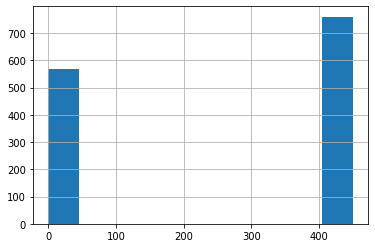

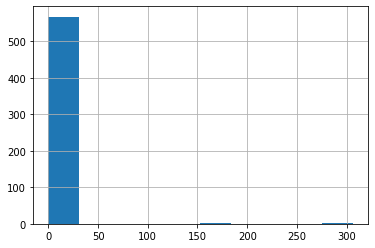

(569, 450) (550, 450)


In [190]:
df_small.isnull().sum(axis=1).hist();
plt.show()
df_small.isnull().sum(axis=1)[df_small.isnull().sum(axis=1) < 400].hist();
plt.show()
print(df_small[df_small.isnull().sum(axis=1) < 400].shape, df_small[df_small.isnull().sum(axis=1) < 400].dropna().shape)

In [138]:
df_small.dropna(inplace=True)
print(df_small.shape)

(550, 456)


In [115]:
df_small[df_small.isnull().sum(axis=1) < 400].isnull().sum().sort_values().iloc[-8:]

Xetra_A1K023_Close_agg_60min     3
Xetra_A1K023_Volume_agg_60min    3
London_DLAR_Close_agg_60min      5
London_DLAR_Volume_agg_60min     5
London_GENL_Close_agg_60min      7
London_GENL_Volume_agg_60min     7
London_IPF_Close_agg_60min       7
London_IPF_Volume_agg_60min      7
dtype: int64

In [100]:
# London_GENL, London_IPF - exclude;

In [116]:
df_small[df_small.isnull().sum(axis=1) < 400].shape

(569, 456)

In [156]:
cols_delete = [
    'London_FBRIC_Volume_agg_60min',
    'London_FBRIC_Close_agg_60min',
    'London_LLOY_Volume_agg_60min',
    'London_LLOY_Close_agg_60min',
    'London_TSCO_Volume_agg_60min',
    'London_TSCO_Close_agg_60min'
]

df_small = df_small.loc[:, ~df_small.columns.isin(cols_delete)].copy()

In [158]:
print(df_small.shape, df_small.dropna().shape)

(550, 450) (550, 450)


In [159]:
df = df_small.copy()
print(df.shape, df.dropna().shape)

(550, 450) (550, 450)


saving df_small Q1

In [160]:
dft = df.T.copy()

In [161]:
dft.shape, dft.dropna().shape, dft.dropna(axis=1).shape

((450, 550), (450, 550), (450, 550))

In [162]:
#dft.to_csv(os.path.join(OUT_FOLDER_CLUSTERS, "2018_Q1_European_450_agg_60min_round4.txt"), header=False)

In [163]:
dft_cut350 = dft.iloc[:350, :].copy()

In [164]:
dft_cut350.shape

(350, 550)

In [165]:
#dft_cut350.to_csv(os.path.join(OUT_FOLDER_CLUSTERS, "2018_Q1_European_450_agg_60min_round4_CUT_350vectors.txt"), header=False)

In [166]:
dft_cut140 = dft.iloc[:140, :].copy()

In [167]:
dft_cut140.shape

(140, 550)

In [168]:
#dft_cut140.to_csv(os.path.join(OUT_FOLDER_CLUSTERS, "2018_Q1_European_450_agg_60min_round4_CUT_140vectors.txt"), header=False)

In [169]:
dft_cut80 = dft.iloc[:80, :].copy()

In [170]:
dft_cut80.shape

(80, 550)

In [171]:
# dft_cut80.to_csv(os.path.join(OUT_FOLDER_CLUSTERS, "2018_Q1_European_450_agg_60min_round4_CUT_80vectors.txt"), header=False)

```python
"2018_Q1_European_450_agg_60min_round4.txt"  # defautlt (450 vectors)


"2018_European_450_agg_60min_round4_CUT_350vectors.txt"


"2018_European_450_agg_60min_round4_CUT_140vectors.txt"


"2018_European_450_agg_60min_round4_CUT_80vectors.txt"
```

Preprocessing:
    
    1. European cluster (14 stock exchanges, 540 stocks).
    2. Selected 225 stocks from London and Xetra stock exchanges.
    2. Took Close price + Volume for each => 450 vectors.
    3. The data was taken for Q1 of the year 2018, aggregated to 1 hour frequency.
    4. Initial vector length: 1329. 
        Only those observations, for which less than 400 vectors (out of 450) have missing values were left => 
        that resulted in a vector length of 569. Then we decided to drop the remaining null values => length became 550.
    
    Thus, resulting dataset (transposed, so that rows are vectors) is: (450, 550).
    "2018_European_450_agg_60min_round4.txt"